In [6]:
import keras
from sklearn.model_selection import train_test_split
import os,re, glob
import logging
import pandas as pd
import re,pyensembl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition
import pickle
import tensorflow as tf

%matplotlib inline
sns.set_style('whitegrid')

session_conf = tf.ConfigProto(
      intra_op_parallelism_threads=20,
      inter_op_parallelism_threads=20)
sess = tf.Session(config=session_conf)

from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking, Dropout, Conv1D, Activation
from keras.layers.wrappers import Bidirectional, TimeDistributed
K.set_session(sess)


In [57]:
ws = 5e6
with open("/srv/shared/vanloo/rna2cn/SRP052901/feaures/features_ws5mb.pickle", 'rb') as f:
    X, Y, mask = pickle.load(f)
    
chr_boundaries = mask.reshape((22, -1)).sum(axis=1).cumsum()

### Train-Test Split

This makes a train-test at the single cell level. Training actually occurs at the *chromosome* level so this is actaully not ideal, but for visualistion we want to think about whole cells

In [41]:
# Move the chromosomes of each cell into a new axis so we can select
# the test set to contain whole cells
X_cell = X.reshape((-1,22) + X.shape[1:])
Y_cell = Y.reshape((-1,22) + Y.shape[1:])

In [42]:
X_train_cell, X_test_cell, Y_train_cell, Y_test_cell = train_test_split(X_cell, Y_cell, test_size=0.25)
X_train = X_train_cell.reshape((-1, ) + X_train_cell.shape[2:])
X_test = X_test_cell.reshape((-1, ) + X_test_cell.shape[2:])
Y_train = Y_train_cell.reshape((-1, ) + Y_train_cell.shape[2:])
Y_test = Y_test_cell.reshape((-1, ) + Y_test_cell.shape[2:])

### Define the model

In [59]:
model = Sequential()
model.add(Masking(mask_value=-1, input_shape=X.shape[1:]))

#model.add(Conv1D(32,10, padding='same', input_shape=X.shape[1:]))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
#model.add(Attention())
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
#model.add(Bidirectional(LSTM(64, return_sequences=True)))
#model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(6, activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mse'])

In [60]:
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    batch_size=5, epochs=30)

Train on 418 samples, validate on 154 samples
Epoch 1/30
418/418 [==============================] - 10s - loss: 1.1202 - acc: 0.5499 - mean_squared_error: 0.1020 - val_loss: 1.0633 - val_acc: 0.5447 - val_mean_squared_error: 0.0963
Epoch 2/30
418/418 [==============================] - 9s - loss: 0.9723 - acc: 0.6056 - mean_squared_error: 0.0902 - val_loss: 1.0118 - val_acc: 0.5964 - val_mean_squared_error: 0.0917
Epoch 3/30
418/418 [==============================] - 9s - loss: 0.8485 - acc: 0.6549 - mean_squared_error: 0.0791 - val_loss: 0.8983 - val_acc: 0.6422 - val_mean_squared_error: 0.0827
Epoch 4/30
418/418 [==============================] - 9s - loss: 0.8869 - acc: 0.6405 - mean_squared_error: 0.0825 - val_loss: 0.9044 - val_acc: 0.6280 - val_mean_squared_error: 0.0861
Epoch 5/30
418/418 [==============================] - 9s - loss: 0.8472 - acc: 0.6602 - mean_squared_error: 0.0801 - val_loss: 0.8972 - val_acc: 0.6409 - val_mean_squared_error: 0.0837
Epoch 6/30
418/418 [========

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


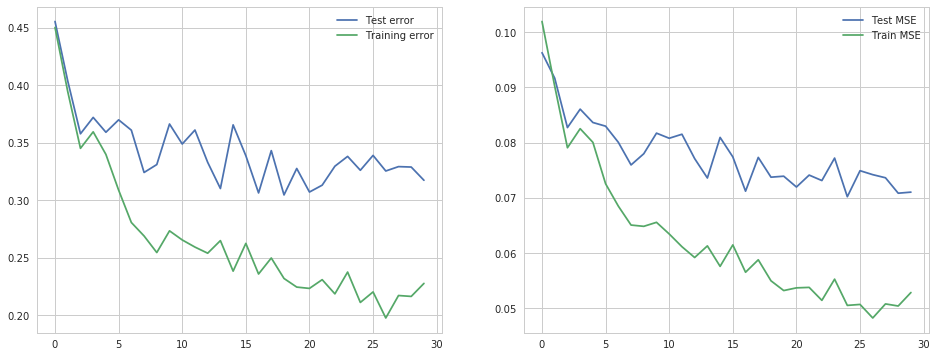

In [63]:
plt.figure(figsize=(16,6))

plt.subplot(121).plot(1 - np.array(history.history['val_acc']), label='Test error')
plt.subplot(121).plot(1 - np.array(history.history['acc']), label='Training error')
plt.legend()

plt.subplot(122).plot(np.array(history.history['val_mean_squared_error']), label='Test MSE')
plt.subplot(122).plot(np.array(history.history['mean_squared_error']), label='Train MSE')
plt.legend()

In [48]:
pred = model.predict(X_test)

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


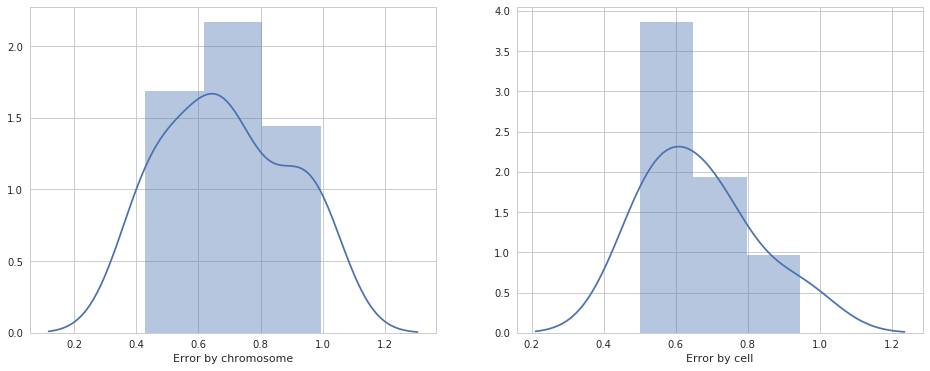

In [47]:
cell_metrics = np.array([model.evaluate(X_test[22*i:22*(i+1)], Y_test[22*i:22*(i+1)], verbose=0) for i in range(X_test.shape[0]//22)])
chromosome_metrics = np.array([model.evaluate(X_test[i::22], Y_test[i::22], verbose=0) for i in range(22)])
metrics = np.array([model.evaluate(X_test[i:i+1], Y_test[i:i+1], verbose=0) for i in range(X_test.shape[0])])

plt.figure(figsize=(16,6))
sns.distplot(chromosome_metrics[:,1], ax=plt.subplot(121))
plt.subplot(121).set_xlabel('Error by chromosome')
sns.distplot(cell_metrics[:,1], ax=plt.subplot(122))
plt.subplot(122).set_xlabel('Error by cell')

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


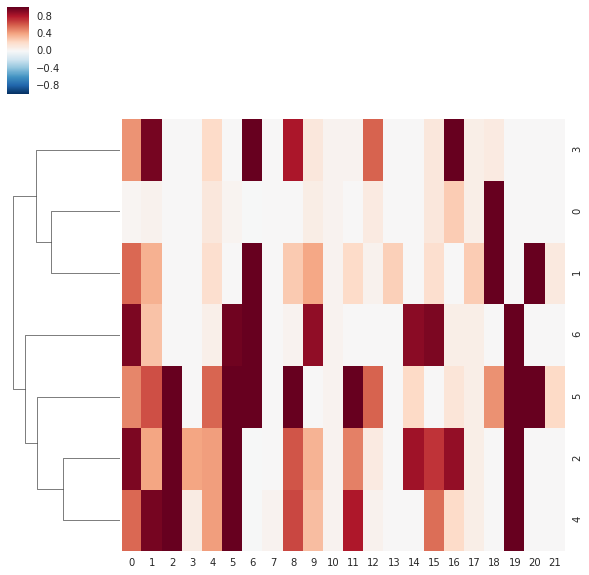

In [49]:
sns.clustermap(1-metrics[:,1].reshape((-1,22)), col_cluster=False)

In [50]:
def plot_genome(data, ax=None, pad=float('nan')):
    if np.isnan(pad):
        comp = np.isnan
    else:
        comp = lambda x:x==pad
        
    if ax is None:
        plt.figure(figsize=(24,2))
        ax = plt.gca()
        
    data = np.ravel(data, order='C')
    collapsed, boundaries = [], []
    
    for i,d in enumerate(data):
        if comp(d):
            if ~comp(data[i-1]):
                boundaries.append(len(collapsed))
                collapsed.append(d)
        else:
            collapsed.append(d)
    ax.plot(range(len(collapsed)), collapsed, '.', color='black')
    ax.vlines(boundaries, 0,6, color='gray')
    ax.set_ylim((0,5))
    

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


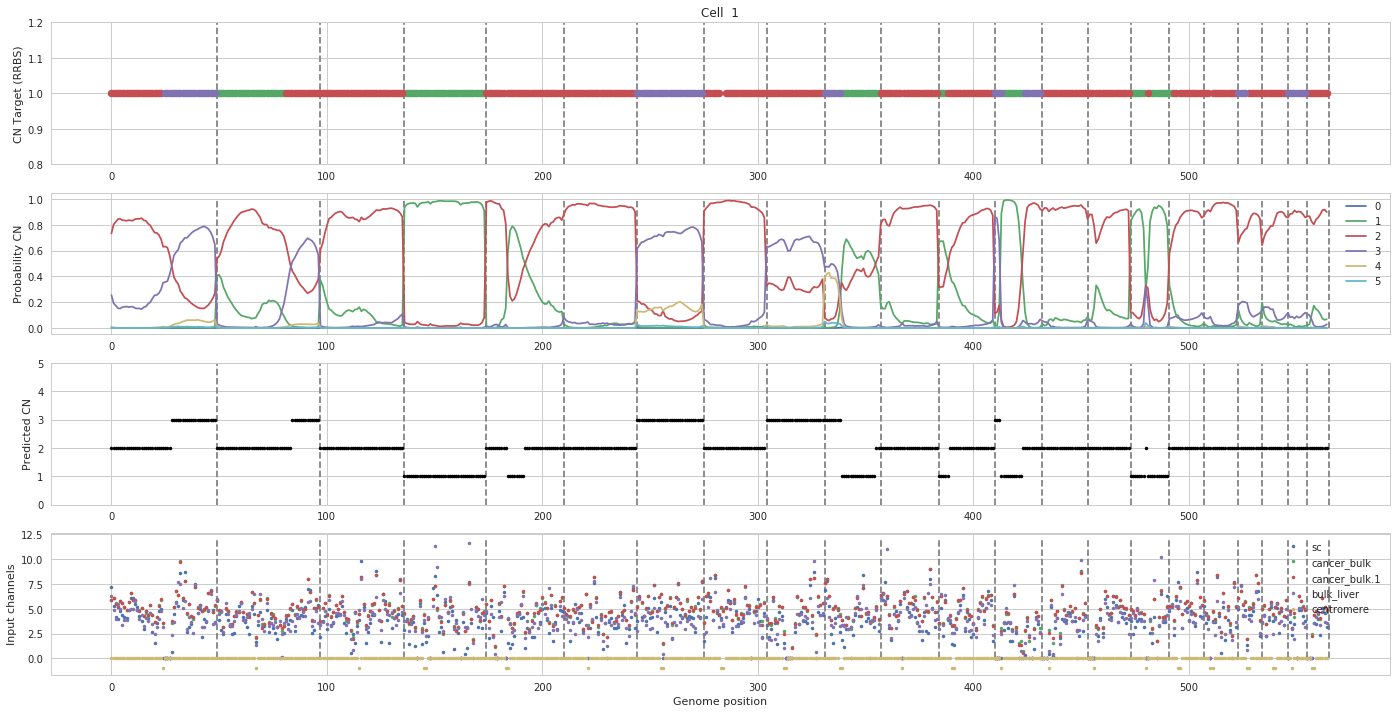

In [58]:
plt.figure(figsize=(24, 12))
i=0

plt.subplot(411).plot(Y[i*22:(i+1)*22].reshape((-1,6))[mask],'.', ms=15)
plt.subplot(411).set_ylim((0.8, 1.2))
plt.subplot(411).set_ylabel("CN Target (RRBS)")
plt.vlines(chr_boundaries, 0.8,1.2,linestyle='dashed', color='gray')
plt.title('Cell {0:2d}'.format(i+1))

for j in range(6):
    plt.subplot(412).plot(pred[i*22:(i+1)*22,:,j].reshape((-1))[mask], label=str(j))
plt.subplot(412).set_ylabel("Probability CN")
plt.subplot(412).vlines(chr_boundaries, 0.,1.,linestyle='dashed', color='gray')
plt.subplot(412).legend()

plt.subplot(413).plot(pred[i*22:(i+1)*22].argmax(axis=-1).reshape((-1))[mask], '.', color='black')
plt.subplot(413).set_ylabel("Predicted CN")
plt.subplot(413).vlines(chr_boundaries, 0,5,linestyle='dashed', color='gray')

plt.subplot(413).set_ylim((0,5))

for j,t in enumerate(["sc",'cancer_bulk', 'cancer_bulk.1', 'bulk_liver', 'centromere'] ):
    plt.subplot(414).plot(X[i*22:(i+1)*22,:,j].reshape((-1))[mask], '.', label=t)

plt.subplot(414).vlines(chr_boundaries, 0,12,linestyle='dashed', color='gray')
plt.subplot(414).legend()
plt.subplot(414).set_ylabel("Input channels")

plt.subplot(414).set_xlabel("Genome position")

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


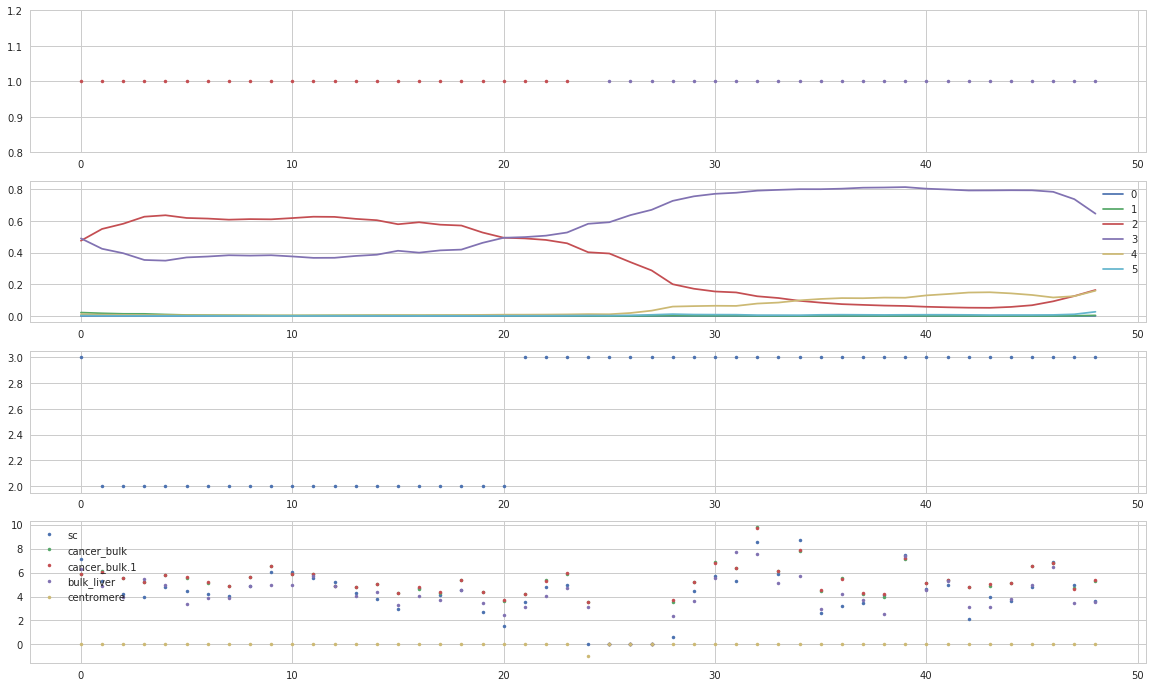

In [93]:
plt.figure(figsize=(20, 12))
i=0
plt.subplot(411).plot(Y[i].reshape((-1,6)),'.', linewidth=10)
plt.subplot(411).set_ylim((0.8, 1.2))

for j in range(pred.shape[2]):
    plt.subplot(412).plot(pred[i,:,j], label=str(j))
plt.subplot(412).legend()

plt.subplot(413).plot(pred.argmax(axis=-1)[i].reshape((-1)), '.')

for j,t in enumerate(["sc",'cancer_bulk', 'cancer_bulk.1', 'bulk_liver', 'centromere'] ):
    plt.subplot(414).plot(X[i,:,j].reshape((-1)), '.', label=t)
plt.subplot(414).legend(loc=2)